# Model Building
## *This Notebook is written using R kernel*

# CONTENTS
---
1.	[Preparing Data for Analysis](#prep)
2.	[Machine Learning Models](#models)
    1. [Logistic Regression](#lr)     
    2. [Logistic Regression using SMOTE](#lr_smote)       
    3. [Logistic Regression using Regularization](#lr_reg)
    4. [Decision Trees](#dt)
    5. [Random Forest](#rf)
    6. [Gradient Boosting Machine](#gbm)
3.	[Variable Importance](#vimp)

---

# 1.	Preparing Data for Analysis
<a id = 'prep'></a>
---

In [1]:
# clear environment variables
rm(list = ls())

# set working directory
#setwd("")

options(scipen=999) # avoids scintific notation in output

In [2]:
# Loading required libraries
library(car) # to find vif
library(MASS) # to implement stepAIC
library(ROCR) # to plot ROC and find best cut-off
library(pROC) # to find auc
library(caret) # to calculate performance(recall/kappa)
library(DMwR) # to SMOTE
library(rpart) # decision Trees
library(rpart.plot) # plot decision Trees
library(h2o) # GLM,RandomForest,GBM
library(randomForest)

Warning message:
"package 'car' was built under R version 3.4.4"Loading required package: carData
Warning message:
"package 'carData' was built under R version 3.4.4"Warning message:
"package 'ROCR' was built under R version 3.4.4"Loading required package: gplots
Warning message:
"package 'gplots' was built under R version 3.4.4"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
"package 'pROC' was built under R version 3.4.4"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'DMwR' was built under R version 3.4.4"Loading required package: grid
Warning message:
"package 'rpart.plot' was built under R version 3.4.4"Warning message:
"package 'h2o' was built under R version 3.4.4"
--------------------------------------------------------------

In [3]:
# load data
df = read.csv("data/dataCleaned.csv")

# list features
names(df)

[1] "VISA_CLASS"                  "AGENT_REPRESENTING_EMPLOYER"
 [3] "TOTAL_WORKERS"               "NEW_EMPLOYMENT"             
 [5] "CONTINUED_EMPLOYMENT"        "CHANGE_PREVIOUS_EMPLOYMENT" 
 [7] "NEW_CONCURRENT_EMPLOYMENT"   "CHANGE_EMPLOYER"            
 [9] "AMENDED_PETITION"            "FULL_TIME_POSITION"         
[11] "PW_WAGE_LEVEL"               "PW_SOURCE"                  
[13] "WAGE_RATE_OF_PAY_FROM"       "H1B_DEPENDENT"              
[15] "WILLFUL_VIOLATOR"            "SUPPORT_H1B"                
[17] "LABOR_CON_AGREE"             "CASE_STATUS"                
[19] "BUFFER_DAYS"                 "BUFFER_DAYS_BOOL"           
[21] "ABOVE_PW"

In [4]:
# Understand the data structure
str(df)

'data.frame':	99792 obs. of  21 variables:
 $ VISA_CLASS                 : Factor w/ 4 levels "E-3 Australian",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ AGENT_REPRESENTING_EMPLOYER: Factor w/ 3 levels "missing","N",..: 3 2 2 3 2 2 3 2 2 2 ...
 $ TOTAL_WORKERS              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ NEW_EMPLOYMENT             : int  0 1 1 0 0 1 0 1 1 1 ...
 $ CONTINUED_EMPLOYMENT       : int  1 0 0 0 1 0 1 0 0 0 ...
 $ CHANGE_PREVIOUS_EMPLOYMENT : int  0 0 0 0 0 0 0 0 0 0 ...
 $ NEW_CONCURRENT_EMPLOYMENT  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ CHANGE_EMPLOYER            : int  0 0 0 1 0 0 0 0 0 0 ...
 $ AMENDED_PETITION           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ FULL_TIME_POSITION         : Factor w/ 2 levels "N","Y": 2 2 2 2 2 2 2 2 2 2 ...
 $ PW_WAGE_LEVEL              : Factor w/ 5 levels "Level I","Level II",..: 2 1 4 2 2 1 4 1 1 1 ...
 $ PW_SOURCE                  : Factor w/ 3 levels "CBA","OES","Other": 2 2 2 2 2 2 2 2 2 3 ...
 $ WAGE_RATE_OF_PAY_FROM      : num  90000 48000 79500 92000 

In [5]:
# View summary statistics
summary(df)

           VISA_CLASS    AGENT_REPRESENTING_EMPLOYER TOTAL_WORKERS    
 E-3 Australian : 4033   missing: 1477               Min.   :  1.000  
 H-1B           :95126   N      :31936               1st Qu.:  1.000  
 H-1B1 Chile    :  290   Y      :66379               Median :  1.000  
 H-1B1 Singapore:  343                               Mean   :  2.764  
                                                     3rd Qu.:  1.000  
                                                     Max.   :200.000  
 NEW_EMPLOYMENT     CONTINUED_EMPLOYMENT CHANGE_PREVIOUS_EMPLOYMENT
 Min.   :  0.0000   Min.   : 0.0000      Min.   : 0.0000           
 1st Qu.:  0.0000   1st Qu.: 0.0000      1st Qu.: 0.0000           
 Median :  0.0000   Median : 0.0000      Median : 0.0000           
 Mean   :  0.8336   Mean   : 0.5733      Mean   : 0.2691           
 3rd Qu.:  0.0000   3rd Qu.: 1.0000      3rd Qu.: 0.0000           
 Max.   :200.0000   Max.   :55.0000      Max.   :75.0000           
 NEW_CONCURRENT_EMPLOYMENT 

In [6]:
# re-level VISA_CLASS (to remove spce and symbols)
levels(df$VISA_CLASS)=c("E3","H1B","H1B1Chile","H1B1")
table(df$VISA_CLASS)


       E3       H1B H1B1Chile      H1B1 
     4033     95126       290       343 

In [7]:
# Renaming class levels; DENIED cases are critical (DENIED:1 & CERTIFIED:0)
df$CASE_STATUS = as.factor(ifelse(df$CASE_STATUS=="DENIED",1,0))

In [8]:
# Split data to train(80%) and test(20%) using stratified sampling
library(caTools)
set.seed(123)
train_rows = sample.split(df$CASE_STATUS, SplitRatio=0.8)
train = df[ train_rows,]
test  = df[!train_rows,]

print("Train Class Ratio")
print(prop.table(table(train$CASE_STATUS)))
print("Test Class Ratio")
print(prop.table(table(test$CASE_STATUS)))

[1] "Train Class Ratio"

         0          1 
0.90046847 0.09953153 
[1] "Test Class Ratio"

         0          1 
0.90049103 0.09950897 


Warning message:
"package 'corrplot' was built under R version 3.4.4"corrplot 0.84 loaded


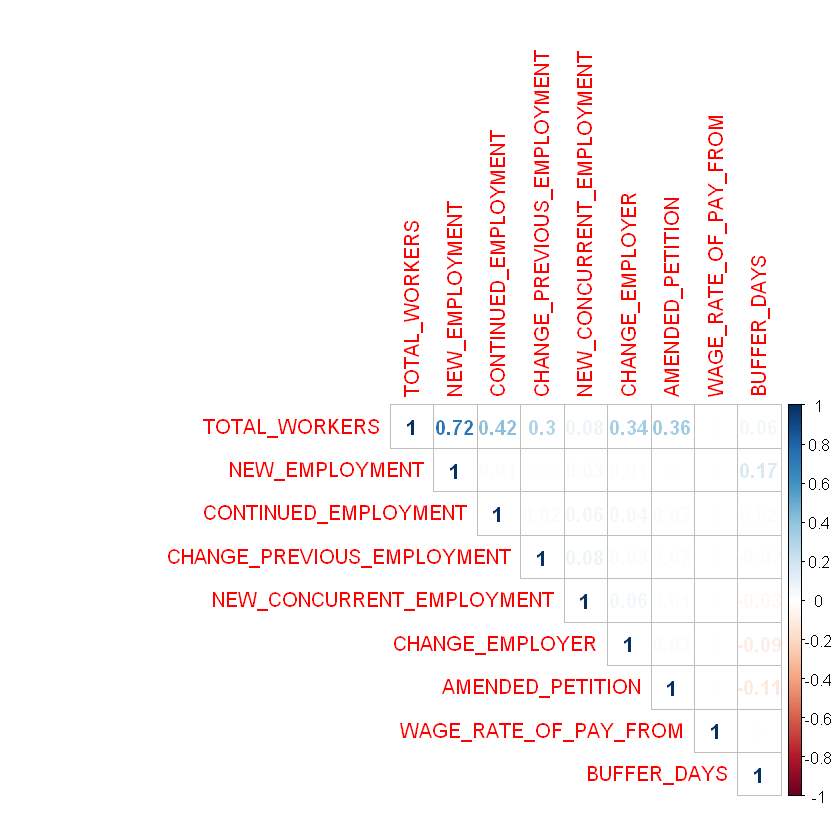

In [9]:
# Correlation among numerical attributes
library(corrplot)
corrplot(cor(train[c("TOTAL_WORKERS","NEW_EMPLOYMENT","CONTINUED_EMPLOYMENT",
                  "CHANGE_PREVIOUS_EMPLOYMENT","NEW_CONCURRENT_EMPLOYMENT",
                  "CHANGE_EMPLOYER","AMENDED_PETITION","WAGE_RATE_OF_PAY_FROM",
                  "BUFFER_DAYS")]),type = "upper",method = c("number"))

---
# 2.	Machine Learning Models
<a id = 'models'></a>


## A. Logistic Regression
<a id = 'lr'></a>

In [10]:
# Logistic regression model using all attributes
model_lr <- glm(CASE_STATUS ~ ., family = binomial(link = 'logit'), data = train)

# model summary
summary(model_lr)


Call:
glm(formula = CASE_STATUS ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7714  -0.3513  -0.2261  -0.1598   4.4495  

Coefficients:
                                      Estimate        Std. Error z value
(Intercept)                    35.011048450287   80.511591780524   0.435
VISA_CLASSH1B                  -1.962411559828    0.175507450667 -11.181
VISA_CLASSH1B1Chile            -0.192746555767    0.204113712753  -0.944
VISA_CLASSH1B1                 -0.449182098513    0.199560202073  -2.251
AGENT_REPRESENTING_EMPLOYERN  -19.161615357107   80.503151998433  -0.238
AGENT_REPRESENTING_EMPLOYERY  -19.576029964044   80.503141505433  -0.243
TOTAL_WORKERS                  -0.053915917602    0.012184974259  -4.425
NEW_EMPLOYMENT                  0.046003430470    0.012332048923   3.730
CONTINUED_EMPLOYMENT           -0.080148163563    0.020403266573  -3.928
CHANGE_PREVIOUS_EMPLOYMENT      0.045781847242   

In [11]:
# Few attribues are insignificant(may have multicollinearity)
# Check Multi-collinearity using VIF
vif(model_lr)

,GVIF,Df,GVIF^(1/(2*Df))
VISA_CLASS,12.116607,3,1.515526
AGENT_REPRESENTING_EMPLOYER,1.181549,2,1.042588
TOTAL_WORKERS,26.165031,1,5.115177
NEW_EMPLOYMENT,19.860713,1,4.456536
CONTINUED_EMPLOYMENT,1.446793,1,1.202827
CHANGE_PREVIOUS_EMPLOYMENT,2.502602,1,1.581961
NEW_CONCURRENT_EMPLOYMENT,1.291775,1,1.136563
CHANGE_EMPLOYER,2.563698,1,1.601155
AMENDED_PETITION,2.877289,1,1.696257
FULL_TIME_POSITION,1.029426,1,1.014606


In [12]:
# dropping H1B_DEPENDENT
model_vif1 = glm(CASE_STATUS ~ .-H1B_DEPENDENT, family = binomial(link = 'logit'), data = train)
vif(model_vif1)

,GVIF,Df,GVIF^(1/(2*Df))
VISA_CLASS,12.156998,3,1.516367
AGENT_REPRESENTING_EMPLOYER,1.181044,2,1.042477
TOTAL_WORKERS,26.522348,1,5.149985
NEW_EMPLOYMENT,20.239766,1,4.498863
CONTINUED_EMPLOYMENT,1.451725,1,1.204876
CHANGE_PREVIOUS_EMPLOYMENT,2.484510,1,1.576233
NEW_CONCURRENT_EMPLOYMENT,1.298042,1,1.139317
CHANGE_EMPLOYER,2.608661,1,1.615135
AMENDED_PETITION,2.827278,1,1.681451
FULL_TIME_POSITION,1.029469,1,1.014627


In [13]:
# dropping H1B_DEPENDENT and TOTAL_WORKERS
model_vif2 = glm(CASE_STATUS ~ .-H1B_DEPENDENT-TOTAL_WORKERS, family = binomial(link = 'logit'), data = train)
vif(model_vif2)

,GVIF,Df,GVIF^(1/(2*Df))
VISA_CLASS,12.157837,3,1.516385
AGENT_REPRESENTING_EMPLOYER,1.182022,2,1.042693
NEW_EMPLOYMENT,1.025988,1,1.012911
CONTINUED_EMPLOYMENT,1.120939,1,1.058744
CHANGE_PREVIOUS_EMPLOYMENT,1.028815,1,1.014305
NEW_CONCURRENT_EMPLOYMENT,1.014375,1,1.007162
CHANGE_EMPLOYER,1.049251,1,1.024330
AMENDED_PETITION,1.052318,1,1.025826
FULL_TIME_POSITION,1.029358,1,1.014573
PW_WAGE_LEVEL,1.958037,4,1.087621


In [14]:
# dropping H1B_DEPENDENT, TOTAL_WORKERS and VISA_CLASS(WILLFUL_VIOLATOR can be useful)
model_vif2 = glm(CASE_STATUS ~ .-H1B_DEPENDENT-TOTAL_WORKERS-VISA_CLASS, family = binomial(link = 'logit'), data = train)
vif(model_vif2)

,GVIF,Df,GVIF^(1/(2*Df))
AGENT_REPRESENTING_EMPLOYER,1.177679,2,1.041734
NEW_EMPLOYMENT,1.026088,1,1.012960
CONTINUED_EMPLOYMENT,1.121465,1,1.058992
CHANGE_PREVIOUS_EMPLOYMENT,1.028631,1,1.014214
NEW_CONCURRENT_EMPLOYMENT,1.014280,1,1.007114
CHANGE_EMPLOYER,1.050243,1,1.024814
AMENDED_PETITION,1.054114,1,1.026701
FULL_TIME_POSITION,1.029018,1,1.014405
PW_WAGE_LEVEL,1.955523,4,1.087446
PW_SOURCE,1.641828,2,1.131962


In [15]:
# summary after removing multicollinearity
summary(model_vif2)


Call:
glm(formula = CASE_STATUS ~ . - H1B_DEPENDENT - TOTAL_WORKERS - 
    VISA_CLASS, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7747  -0.3558  -0.2286  -0.1628   5.0736  

Coefficients:
                                     Estimate       Std. Error z value
(Intercept)                   35.717916609222  80.428500436316   0.444
AGENT_REPRESENTING_EMPLOYERN -20.011803327204  80.420003026716  -0.249
AGENT_REPRESENTING_EMPLOYERY -20.455079952621  80.419990059098  -0.254
NEW_EMPLOYMENT                -0.007352048041   0.002765745187  -2.658
CONTINUED_EMPLOYMENT          -0.124055371154   0.019145353793  -6.480
CHANGE_PREVIOUS_EMPLOYMENT    -0.006501296821   0.009547981110  -0.681
NEW_CONCURRENT_EMPLOYMENT      0.093514148032   0.037084247378   2.522
CHANGE_EMPLOYER               -0.005720082953   0.009515425500  -0.601
AMENDED_PETITION              -0.014251386289   0.009858364134  -1.446
FULL_TIME_POSITIONY     

In [16]:
# Using stepAIC to further reduce dimenstion(removes insignificant attibutes)
step = stepAIC(model_vif2, direction="both")

Start:  AIC=31243.45
CASE_STATUS ~ (VISA_CLASS + AGENT_REPRESENTING_EMPLOYER + TOTAL_WORKERS + 
    NEW_EMPLOYMENT + CONTINUED_EMPLOYMENT + CHANGE_PREVIOUS_EMPLOYMENT + 
    NEW_CONCURRENT_EMPLOYMENT + CHANGE_EMPLOYER + AMENDED_PETITION + 
    FULL_TIME_POSITION + PW_WAGE_LEVEL + PW_SOURCE + WAGE_RATE_OF_PAY_FROM + 
    H1B_DEPENDENT + WILLFUL_VIOLATOR + SUPPORT_H1B + LABOR_CON_AGREE + 
    BUFFER_DAYS + BUFFER_DAYS_BOOL + ABOVE_PW) - H1B_DEPENDENT - 
    TOTAL_WORKERS - VISA_CLASS



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                              Df Deviance   AIC
- CHANGE_EMPLOYER              1    31192 31242
- CHANGE_PREVIOUS_EMPLOYMENT   1    31192 31242
<none>                              31191 31243
- AMENDED_PETITION             1    31194 31244
- NEW_CONCURRENT_EMPLOYMENT    1    31197 31247
- NEW_EMPLOYMENT               1    31200 31250
- WAGE_RATE_OF_PAY_FROM        1    31209 31259
- CONTINUED_EMPLOYMENT         1    31270 31320
- PW_SOURCE                    2    31322 31370
- FULL_TIME_POSITION           1    31342 31392
- BUFFER_DAYS_BOOL             1    31730 31780
- SUPPORT_H1B                  2    31744 31792
- WILLFUL_VIOLATOR             2    31828 31876
- LABOR_CON_AGREE              2    32056 32104
- PW_WAGE_LEVEL                4    32392 32436
- BUFFER_DAYS                  1    32402 32452
- AGENT_REPRESENTING_EMPLOYER  2    33544 33592
- ABOVE_PW                     1    37971 38021

Step:  AIC=31241.84
CASE_STATUS ~ AGENT_REPRESENTING_EMPLOYER + NEW_EMPLOYMENT + 
    C

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                              Df Deviance   AIC
- CHANGE_PREVIOUS_EMPLOYMENT   1    31192 31240
<none>                              31192 31242
- AMENDED_PETITION             1    31194 31242
+ CHANGE_EMPLOYER              1    31191 31243
- NEW_CONCURRENT_EMPLOYMENT    1    31197 31245
- NEW_EMPLOYMENT               1    31200 31248
- WAGE_RATE_OF_PAY_FROM        1    31209 31257
- CONTINUED_EMPLOYMENT         1    31274 31322
- PW_SOURCE                    2    31322 31368
- FULL_TIME_POSITION           1    31343 31391
- BUFFER_DAYS_BOOL             1    31731 31779
- SUPPORT_H1B                  2    31744 31790
- WILLFUL_VIOLATOR             2    31831 31877
- LABOR_CON_AGREE              2    32057 32103
- PW_WAGE_LEVEL                4    32392 32434
- BUFFER_DAYS                  1    32433 32481
- AGENT_REPRESENTING_EMPLOYER  2    33550 33596
- ABOVE_PW                     1    37971 38019

Step:  AIC=31240.38
CASE_STATUS ~ AGENT_REPRESENTING_EMPLOYER + NEW_EMPLOYMENT + 
    C

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                              Df Deviance   AIC
<none>                              31192 31240
- AMENDED_PETITION             1    31195 31241
+ CHANGE_PREVIOUS_EMPLOYMENT   1    31192 31242
+ CHANGE_EMPLOYER              1    31192 31242
- NEW_CONCURRENT_EMPLOYMENT    1    31197 31243
- NEW_EMPLOYMENT               1    31201 31247
- WAGE_RATE_OF_PAY_FROM        1    31210 31256
- CONTINUED_EMPLOYMENT         1    31277 31323
- PW_SOURCE                    2    31323 31367
- FULL_TIME_POSITION           1    31343 31389
- BUFFER_DAYS_BOOL             1    31731 31777
- SUPPORT_H1B                  2    31747 31791
- WILLFUL_VIOLATOR             2    31832 31876
- LABOR_CON_AGREE              2    32060 32104
- PW_WAGE_LEVEL                4    32392 32432
- BUFFER_DAYS                  1    32435 32481
- AGENT_REPRESENTING_EMPLOYER  2    33553 33597
- ABOVE_PW                     1    37972 38018


In [17]:
# Building model using varables selected by AIC
model_stepAIC = glm(CASE_STATUS ~ AGENT_REPRESENTING_EMPLOYER + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + NEW_CONCURRENT_EMPLOYMENT + AMENDED_PETITION + 
    FULL_TIME_POSITION + PW_WAGE_LEVEL + PW_SOURCE + WAGE_RATE_OF_PAY_FROM + 
    WILLFUL_VIOLATOR + SUPPORT_H1B + LABOR_CON_AGREE + BUFFER_DAYS + 
    BUFFER_DAYS_BOOL + ABOVE_PW, family = binomial(link = 'logit'), data = train)
summary(model_stepAIC)


Call:
glm(formula = CASE_STATUS ~ AGENT_REPRESENTING_EMPLOYER + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + NEW_CONCURRENT_EMPLOYMENT + AMENDED_PETITION + 
    FULL_TIME_POSITION + PW_WAGE_LEVEL + PW_SOURCE + WAGE_RATE_OF_PAY_FROM + 
    WILLFUL_VIOLATOR + SUPPORT_H1B + LABOR_CON_AGREE + BUFFER_DAYS + 
    BUFFER_DAYS_BOOL + ABOVE_PW, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7744  -0.3555  -0.2286  -0.1634   4.9872  

Coefficients:
                                     Estimate       Std. Error z value
(Intercept)                   35.859722958618  80.301569349854   0.447
AGENT_REPRESENTING_EMPLOYERN -20.136560065127  80.293079310189  -0.251
AGENT_REPRESENTING_EMPLOYERY -20.582352783830  80.293061437854  -0.256
NEW_EMPLOYMENT                -0.007383850731   0.002769113927  -2.667
CONTINUED_EMPLOYMENT          -0.127041604223   0.019059069356  -6.666
NEW_CONCURRENT_EMPLOYMENT      0.092417214261   0.03

In [18]:
# dropping insignificant variable - AGENT_REPRESENTING_EMPLOYER               
model_sig1 = glm(CASE_STATUS ~ AMENDED_PETITION + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + NEW_CONCURRENT_EMPLOYMENT + 
    FULL_TIME_POSITION + PW_WAGE_LEVEL + PW_SOURCE + WAGE_RATE_OF_PAY_FROM + 
    WILLFUL_VIOLATOR + SUPPORT_H1B + LABOR_CON_AGREE + BUFFER_DAYS + 
    BUFFER_DAYS_BOOL + ABOVE_PW, family = binomial(link = 'logit'), data = train)
summary(model_sig1)


Call:
glm(formula = CASE_STATUS ~ AMENDED_PETITION + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + NEW_CONCURRENT_EMPLOYMENT + FULL_TIME_POSITION + 
    PW_WAGE_LEVEL + PW_SOURCE + WAGE_RATE_OF_PAY_FROM + WILLFUL_VIOLATOR + 
    SUPPORT_H1B + LABOR_CON_AGREE + BUFFER_DAYS + BUFFER_DAYS_BOOL + 
    ABOVE_PW, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9774  -0.3600  -0.2322  -0.1706   4.7550  

Coefficients:
                                 Estimate      Std. Error z value
(Intercept)               14.737521633785  1.104926500399  13.338
AMENDED_PETITION          -0.027509456683  0.010497186000  -2.621
NEW_EMPLOYMENT            -0.009753103470  0.002778939317  -3.510
CONTINUED_EMPLOYMENT      -0.095506731365  0.012380862141  -7.714
NEW_CONCURRENT_EMPLOYMENT  0.070096263899  0.036317703872   1.930
FULL_TIME_POSITIONY       -1.027898184659  0.074166076890 -13.859
PW_WAGE_LEVELLevel II     -0.968396850265  0.040025

In [19]:
# dropping insignificant variable - AGENT_REPRESENTING_EMPLOYER and NEW_CONCURRENT_EMPLOYMENT                
model_sig2 = glm(CASE_STATUS ~ AMENDED_PETITION + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + FULL_TIME_POSITION + PW_WAGE_LEVEL + 
    PW_SOURCE + WAGE_RATE_OF_PAY_FROM + WILLFUL_VIOLATOR + 
    SUPPORT_H1B + LABOR_CON_AGREE + BUFFER_DAYS + BUFFER_DAYS_BOOL + ABOVE_PW, 
    family = binomial(link = 'logit'), data = train)
summary(model_sig2)


Call:
glm(formula = CASE_STATUS ~ AMENDED_PETITION + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + FULL_TIME_POSITION + PW_WAGE_LEVEL + 
    PW_SOURCE + WAGE_RATE_OF_PAY_FROM + WILLFUL_VIOLATOR + SUPPORT_H1B + 
    LABOR_CON_AGREE + BUFFER_DAYS + BUFFER_DAYS_BOOL + ABOVE_PW, 
    family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9757  -0.3601  -0.2318  -0.1693   4.7309  

Coefficients:
                              Estimate      Std. Error z value
(Intercept)            14.732335634938  1.104209850975  13.342
AMENDED_PETITION       -0.026920823298  0.010403756050  -2.588
NEW_EMPLOYMENT         -0.009673108035  0.002772677766  -3.489
CONTINUED_EMPLOYMENT   -0.093893684781  0.012382522678  -7.583
FULL_TIME_POSITIONY    -1.034449616023  0.074124050449 -13.956
PW_WAGE_LEVELLevel II  -0.968886073118  0.040024991500 -24.207
PW_WAGE_LEVELLevel III -1.211256885496  0.052882561979 -22.905
PW_WAGE_LEVELLevel IV  -1.10566827720

In [20]:
# predict on train and test
train_predict <- predict(model_sig2,newdata = train,type = "response")
test_predict <- predict(model_sig2,newdata = test,type = "response")

# Calculate AUC
lr_auc = c(auc(train$CASE_STATUS, train_predict),auc(test$CASE_STATUS, test_predict))

In [21]:
# Area Under the Curve
print(paste("Train AUC:",lr_auc[1]))
print(paste("Test AUC:",lr_auc[2]))

[1] "Train AUC: 0.858845535142929"
[1] "Test AUC: 0.863497926953173"


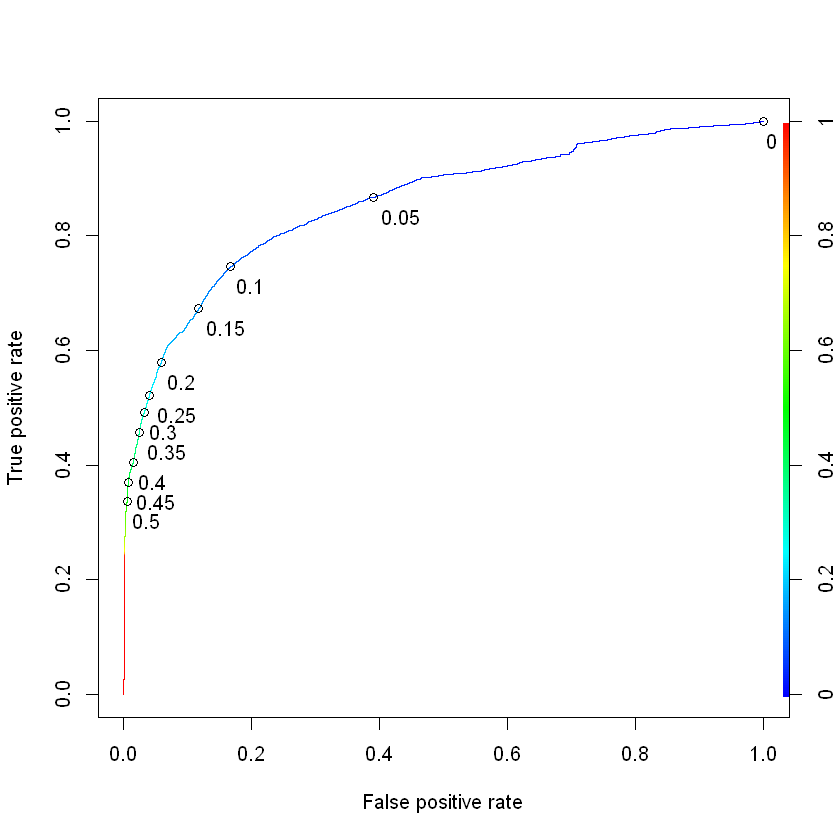

In [22]:
# ROC on train - to finc best cut-off
ROCRpred = prediction(train_predict,train$CASE_STATUS)
ROCRperf  = performance(ROCRpred, "tpr", "fpr")

plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,0.5,by=0.05), 
     text.adj=c(-0.2,1.7))

In [23]:
# performance metrics
confusionMatrix(ifelse(train_predict>0.06,1,0),train$CASE_STATUS,positive = "1")
confusionMatrix(ifelse(test_predict>0.06,1,0),test$CASE_STATUS,positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 50412  1363
         1 21476  6583
                                             
               Accuracy : 0.7139             
                 95% CI : (0.7108, 0.7171)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2492             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.82847            
            Specificity : 0.70126            
         Pos Pred Value : 0.23461            
         Neg Pred Value : 0.97367            
             Prevalence : 0.09953            
         Detection Rate : 0.08246            
   Detection Prevalence : 0.35147            
      Balanced Accuracy : 0.76486            
                                             
       'Positive' Class : 1                  
    

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12587   326
         1  5385  1660
                                             
               Accuracy : 0.7138             
                 95% CI : (0.7075, 0.7201)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2514             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.83585            
            Specificity : 0.70037            
         Pos Pred Value : 0.23563            
         Neg Pred Value : 0.97475            
             Prevalence : 0.09951            
         Detection Rate : 0.08317            
   Detection Prevalence : 0.35299            
      Balanced Accuracy : 0.76811            
                                             
       'Positive' Class : 1                  
    

---
## B. Logistic Regression using SMOTE
<a id = 'lr_smote'></a>

In [24]:
# Applying SMOTE to handle class-imbalance
train_smote <- SMOTE(CASE_STATUS ~ ., train, perc.over = 300, perc.under=200)

In [25]:
# proportion of target class
prop.table(table(train_smote$CASE_STATUS))


  0   1 
0.6 0.4 

In [26]:
# Logistic Regression on SMOTE-data
model_smote = glm(CASE_STATUS ~ AMENDED_PETITION + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + FULL_TIME_POSITION + PW_WAGE_LEVEL + 
    PW_SOURCE + WAGE_RATE_OF_PAY_FROM + WILLFUL_VIOLATOR + 
    SUPPORT_H1B + LABOR_CON_AGREE + BUFFER_DAYS + BUFFER_DAYS_BOOL + ABOVE_PW, 
    family = binomial(link = 'logit'), data = train_smote)
summary(model_smote)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = CASE_STATUS ~ AMENDED_PETITION + NEW_EMPLOYMENT + 
    CONTINUED_EMPLOYMENT + FULL_TIME_POSITION + PW_WAGE_LEVEL + 
    PW_SOURCE + WAGE_RATE_OF_PAY_FROM + WILLFUL_VIOLATOR + SUPPORT_H1B + 
    LABOR_CON_AGREE + BUFFER_DAYS + BUFFER_DAYS_BOOL + ABOVE_PW, 
    family = binomial(link = "logit"), data = train_smote)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2775  -0.5145  -0.3341   0.0580   4.6480  

Coefficients:
                               Estimate       Std. Error z value
(Intercept)             27.523567118708  55.931541211953   0.492
AMENDED_PETITION        -0.071221662876   0.010725864760  -6.640
NEW_EMPLOYMENT          -0.005757713366   0.002056327437  -2.800
CONTINUED_EMPLOYMENT    -0.080792188344   0.009815789912  -8.231
FULL_TIME_POSITIONY     -2.797595777961   0.049533976829 -56.478
PW_WAGE_LEVELLevel II   -0.908361162997   0.030729908036 -29.560
PW_WAGE_LEVELLevel III  -1.002124438666   0.038386253934 -26.106
PW_WAGE_LEVELLe

In [27]:
# predict on train and test
train_predict <- predict(model_smote,newdata = train_smote,type = "response")
test_predict <- predict(model_smote,newdata = test,type = "response")

# Calculate AUC
lr_smote_auc = c(auc(train_smote$CASE_STATUS, train_predict),auc(test$CASE_STATUS, test_predict))

In [28]:
# Area Under the Curve
print(paste("Train AUC:",lr_smote_auc[1]))
print(paste("Test AUC:",lr_smote_auc[2]))

[1] "Train AUC: 0.923705703349421"
[1] "Test AUC: 0.857757768098031"


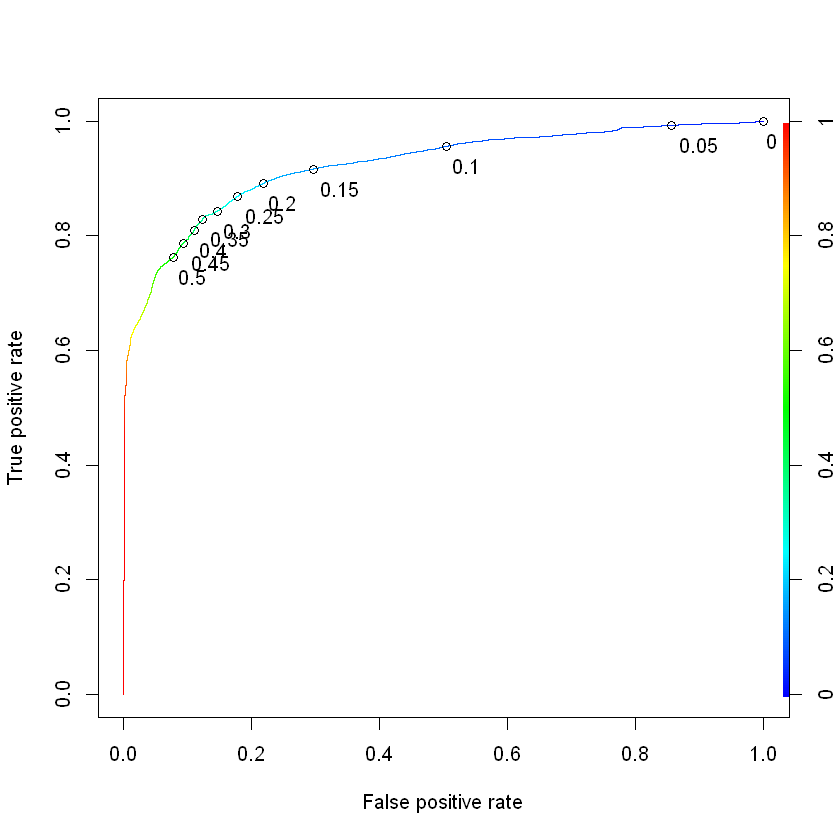

In [29]:
# ROC on train - to finc best cut-off
ROCRpred = prediction(train_predict,train_smote$CASE_STATUS)
ROCRperf  = performance(ROCRpred, "tpr", "fpr")

plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,0.5,by=0.05), 
     text.adj=c(-0.2,1.7))

In [30]:
# performance metrics
confusionMatrix(ifelse(train_predict>0.15,1,0),train_smote$CASE_STATUS,positive = "1")
confusionMatrix(ifelse(test_predict>0.15,1,0),test$CASE_STATUS,positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 33584  2649
         1 14092 29135
                                               
               Accuracy : 0.7893               
                 95% CI : (0.7865, 0.7921)     
    No Information Rate : 0.6                  
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.5859               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.9167               
            Specificity : 0.7044               
         Pos Pred Value : 0.6740               
         Neg Pred Value : 0.9269               
             Prevalence : 0.4000               
         Detection Rate : 0.3667               
   Detection Prevalence : 0.5440               
      Balanced Accuracy : 0.8105               
                                               
       'Positi

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12653   308
         1  5319  1678
                                             
               Accuracy : 0.7181             
                 95% CI : (0.7118, 0.7243)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2587             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.84491            
            Specificity : 0.70404            
         Pos Pred Value : 0.23982            
         Neg Pred Value : 0.97624            
             Prevalence : 0.09951            
         Detection Rate : 0.08408            
   Detection Prevalence : 0.35059            
      Balanced Accuracy : 0.77448            
                                             
       'Positive' Class : 1                  
    

---
## C. Logistic Regression using Regularization
<a id = 'lr_reg'></a>

In [31]:
# Starting h2o
h2o.init(nthreads = -1) # all CPU's used


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\poiga\AppData\Local\Temp\RtmpS0a73f/h2o_poigal_started_from_r.out
    C:\Users\poiga\AppData\Local\Temp\RtmpS0a73f/h2o_poigal_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         6 seconds 495 milliseconds 
    H2O cluster version:        3.16.0.2 
    H2O cluster version age:    4 months and 15 days !!! 
    H2O cluster name:           H2O_started_from_R_poigal_vzd750 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.75 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Ver

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (4 months and 15 days)!
Please download and install the latest version from http://h2o.ai/download/"

In [32]:
# convert train and test to h2o objects
train.hex = as.h2o(train)
test.hex = as.h2o(test)

  |======================================================================| 100%
  |======================================================================| 100%


In [33]:
# GLM with lambda_search to find best lambda(ridge regression)
lca_glm <- h2o.glm(x = setdiff(names(train),"CASE_STATUS"), y = "CASE_STATUS", 
                   balance_classes = TRUE, nfolds = 5, training_frame = train.hex,
                   family = "binomial", lambda_search = TRUE,fold_assignment = "Modulo",
                   seed=12345,keep_cross_validation_predictions = TRUE)

  |======================================================================| 100%


In [34]:
# AUC
perf_train = h2o.performance(lca_glm , train.hex)
perf_test = h2o.performance(lca_glm , test.hex)

# predict on train and test
train_pred = as.data.frame(h2o.predict(lca_glm , train.hex))[,3]
test_pred = as.data.frame(h2o.predict(lca_glm , test.hex))[,3]

# Calculate AUC
lr_reg_auc = c(h2o.auc(perf_train),h2o.auc(perf_test))

  |======================================================================| 100%
  |======================================================================| 100%


In [35]:
# Area Under the Curve
print(paste("Train AUC:",lr_reg_auc[1]))
print(paste("Test AUC:",lr_reg_auc[2]))

[1] "Train AUC: 0.873773540863044"
[1] "Test AUC: 0.879204607525324"


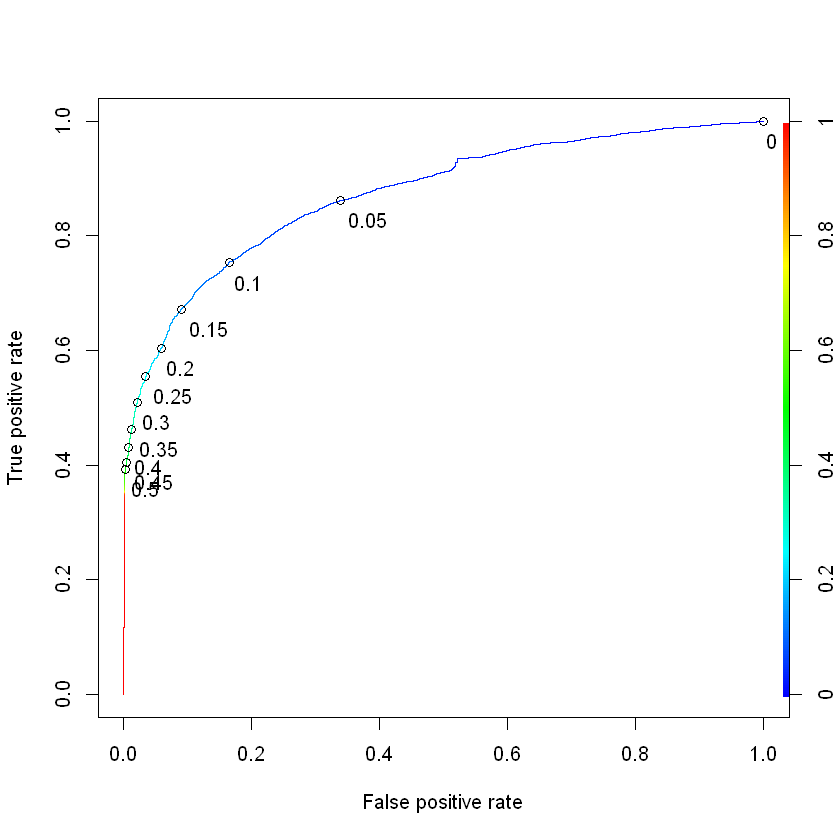

In [36]:
# ROC on train - to finc best cut-off
ROCRpred = prediction(train_pred,train$CASE_STATUS)
ROCRperf  = performance(ROCRpred, "tpr", "fpr")

plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,0.5,by=0.05), 
     text.adj=c(-0.2,1.7))

In [37]:
# performance metrics
confusionMatrix(ifelse(train_pred>0.057,1,0),train$CASE_STATUS,positive = "1")
confusionMatrix(ifelse(test_pred>0.057,1,0),test$CASE_STATUS,positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 50573  1258
         1 21315  6688
                                             
               Accuracy : 0.7173             
                 95% CI : (0.7141, 0.7204)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2568             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.84168            
            Specificity : 0.70350            
         Pos Pred Value : 0.23883            
         Neg Pred Value : 0.97573            
             Prevalence : 0.09953            
         Detection Rate : 0.08377            
   Detection Prevalence : 0.35077            
      Balanced Accuracy : 0.77259            
                                             
       'Positive' Class : 1                  
    

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12633   307
         1  5339  1679
                                             
               Accuracy : 0.7171             
                 95% CI : (0.7108, 0.7233)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2578             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.84542            
            Specificity : 0.70293            
         Pos Pred Value : 0.23924            
         Neg Pred Value : 0.97628            
             Prevalence : 0.09951            
         Detection Rate : 0.08413            
   Detection Prevalence : 0.35164            
      Balanced Accuracy : 0.77417            
                                             
       'Positive' Class : 1                  
    

---
## D. Decision Trees
<a id = 'dt'></a>

In [38]:
#Base Model
model_rpart <- rpart(CASE_STATUS ~ ., data = train, method = "class",
                       control = rpart.control(cp = 0))
summary(model_rpart)
#parms = list(prior = c(0.7, 0.3)

Call:
rpart(formula = CASE_STATUS ~ ., data = train, method = "class", 
    control = rpart.control(cp = 0))
  n= 79834 

              CP nsplit rel error    xerror        xstd
1  0.22954945885      0 1.0000000 1.0000000 0.010645351
2  0.11087339542      1 0.7704505 0.7704505 0.009461789
3  0.00632393657      2 0.6595771 0.6595771 0.008806708
4  0.00358671029     10 0.6003020 0.6228291 0.008574595
5  0.00314623710     12 0.5931286 0.6079789 0.008478428
6  0.00205554157     24 0.5546187 0.5800403 0.008293578
7  0.00201359174     27 0.5484521 0.5718601 0.008238446
8  0.00151019381     28 0.5464385 0.5658193 0.008197429
9  0.00146824398     29 0.5449283 0.5634281 0.008181121
10 0.00138434432     32 0.5405235 0.5625472 0.008175103
11 0.00125849484     33 0.5391392 0.5614145 0.008167356
12 0.00119557010     38 0.5328467 0.5599044 0.008157013
13 0.00113264536     40 0.5304556 0.5576391 0.008141467
14 0.00088094639     42 0.5281903 0.5538636 0.008115474
15 0.00081802165     43 0.5273093 0.54

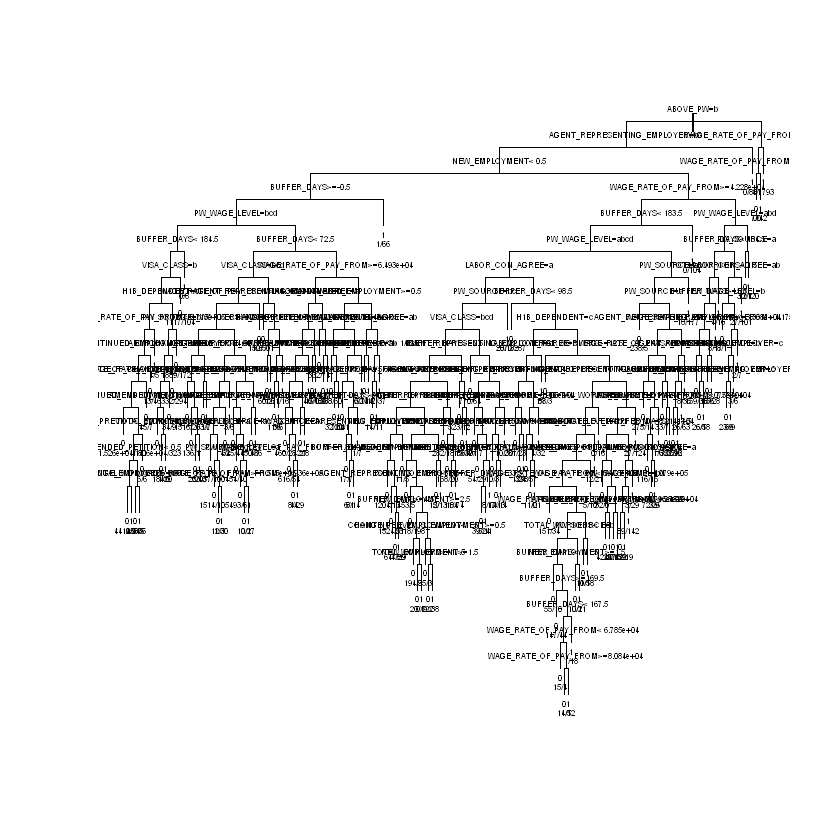

In [39]:
# model_pruned (based on internal cross validation set)
model_pruned = prune(model_rpart, cp = 0.0003)
plot(model_pruned, uniform = TRUE)
text(model_pruned, use.n = TRUE, cex = 0.4)

In [40]:
# predict on train and test
train_predict <- predict(model_pruned, train, type = c("prob"))[,2]
test_predict <- predict(model_pruned, test, type = c("prob"))[,2]

# Calculate AUC
dt_auc = c(auc(train$CASE_STATUS, train_predict),auc(test$CASE_STATUS, test_predict))

In [41]:
# Area Under the Curve
print(paste("Train AUC:",dt_auc[1]))
print(paste("Test AUC:",dt_auc[2]))

[1] "Train AUC: 0.906230909350334"
[1] "Test AUC: 0.909151675796904"


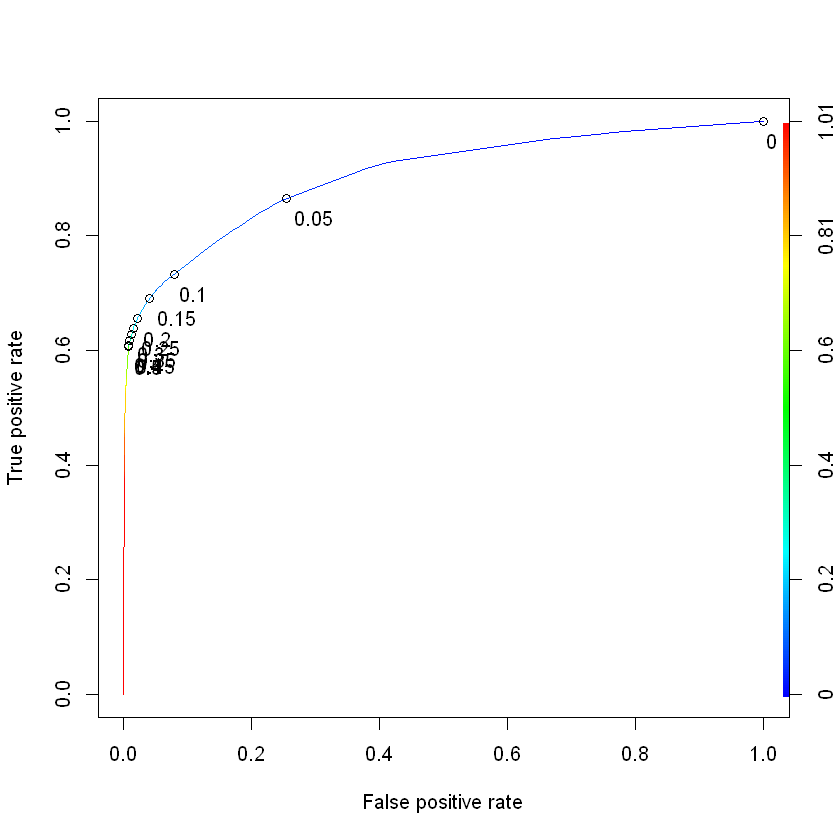

In [42]:
# ROC on train - to finc best cut-off
ROCRpred = prediction(train_predict,train$CASE_STATUS)
ROCRperf  = performance(ROCRpred, "tpr", "fpr")

plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,0.5,by=0.05), 
     text.adj=c(-0.2,1.7))

In [43]:
# performance metrics
confusionMatrix(ifelse(train_predict>0.045,1,0),train$CASE_STATUS,positive = "1")
confusionMatrix(ifelse(test_predict>0.045,1,0),test$CASE_STATUS,positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 51498   970
         1 20390  6976
                                             
               Accuracy : 0.7324             
                 95% CI : (0.7294, 0.7355)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2848             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.87793            
            Specificity : 0.71636            
         Pos Pred Value : 0.25491            
         Neg Pred Value : 0.98151            
             Prevalence : 0.09953            
         Detection Rate : 0.08738            
   Detection Prevalence : 0.34279            
      Balanced Accuracy : 0.79715            
                                             
       'Positive' Class : 1                  
    

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12920   231
         1  5052  1755
                                             
               Accuracy : 0.7353             
                 95% CI : (0.7291, 0.7414)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2898             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.88369            
            Specificity : 0.71890            
         Pos Pred Value : 0.25782            
         Neg Pred Value : 0.98243            
             Prevalence : 0.09951            
         Detection Rate : 0.08793            
   Detection Prevalence : 0.34107            
      Balanced Accuracy : 0.80129            
                                             
       'Positive' Class : 1                  
    

---
## E. Random Forest
<a id = 'rf'></a>

In [44]:
lca_rf = h2o.randomForest(x = setdiff(names(train),"CASE_STATUS"), y = "CASE_STATUS", 
                           ntrees = 50, training_frame = train.hex,fold_assignment = "Modulo",
                           nfolds = 5, seed=12345,keep_cross_validation_predictions = TRUE)

  |======================================================================| 100%


In [45]:
# AUC
perf_train = h2o.performance(lca_rf , train.hex)
perf_test = h2o.performance(lca_rf , test.hex)

# predict on train and test
train_pred = as.data.frame(h2o.predict(lca_rf , train.hex))[,3]
test_pred = as.data.frame(h2o.predict(lca_rf , test.hex))[,3]

# Calculate AUC
rf_auc = c(h2o.auc(perf_train),h2o.auc(perf_test))

  |======================================================================| 100%
  |======================================================================| 100%


In [46]:
# Area Under the Curve
print(paste("Train AUC:",rf_auc[1]))
print(paste("Test AUC:",rf_auc[2]))

[1] "Train AUC: 0.95460894044482"
[1] "Test AUC: 0.931612050545674"


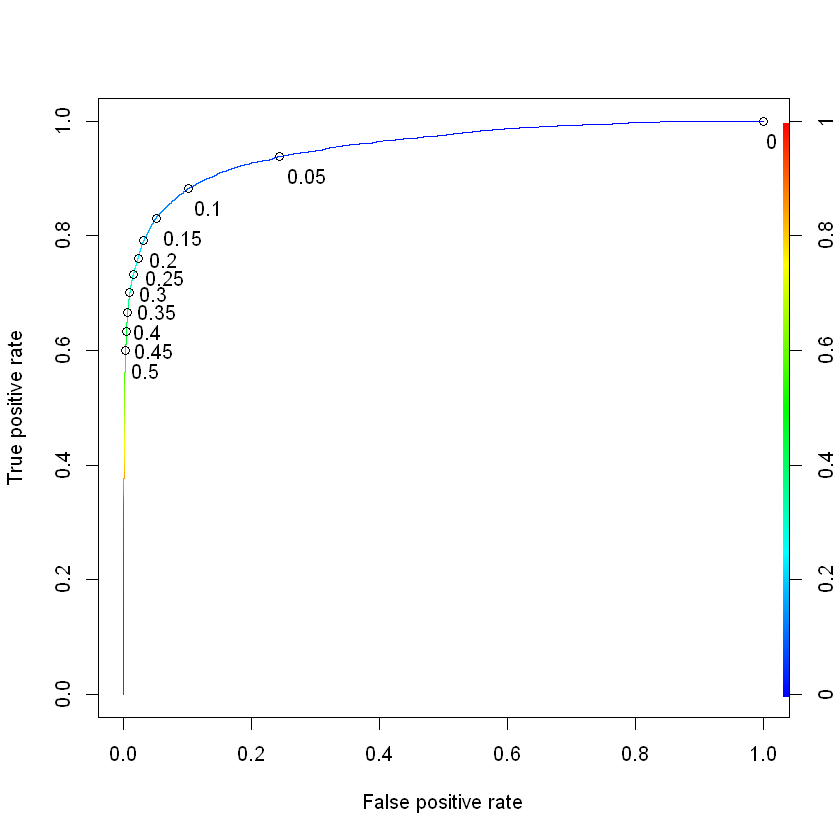

In [47]:
# ROC on train - to finc best cut-off
ROCRpred = prediction(train_pred,train$CASE_STATUS)
ROCRperf  = performance(ROCRpred, "tpr", "fpr")

plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,0.5,by=0.05), 
     text.adj=c(-0.2,1.7))

In [48]:
# performance metrics
confusionMatrix(ifelse(train_pred>0.045,1,0),train$CASE_STATUS,positive = "1")
confusionMatrix(ifelse(test_pred>0.045,1,0),test$CASE_STATUS,positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 52430   442
         1 19458  7504
                                             
               Accuracy : 0.7507             
                 95% CI : (0.7477, 0.7537)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.3264             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.94437            
            Specificity : 0.72933            
         Pos Pred Value : 0.27832            
         Neg Pred Value : 0.99164            
             Prevalence : 0.09953            
         Detection Rate : 0.09400            
   Detection Prevalence : 0.33773            
      Balanced Accuracy : 0.83685            
                                             
       'Positive' Class : 1                  
    

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12832   153
         1  5140  1833
                                             
               Accuracy : 0.7348             
                 95% CI : (0.7286, 0.7409)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.3009             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.92296            
            Specificity : 0.71400            
         Pos Pred Value : 0.26287            
         Neg Pred Value : 0.98822            
             Prevalence : 0.09951            
         Detection Rate : 0.09184            
   Detection Prevalence : 0.34938            
      Balanced Accuracy : 0.81848            
                                             
       'Positive' Class : 1                  
    

---
## F. Gradient Boosting Machine (GBM)
<a id = 'gbm'></a>

In [49]:
lca_gbm = h2o.gbm(x = setdiff(names(train),"CASE_STATUS"), y = "CASE_STATUS", 
                           ntrees = 50, training_frame = train.hex, fold_assignment = "Modulo",##max_depth = 3,min_rows = 2,
                           nfolds = 5, seed=12345,keep_cross_validation_predictions = TRUE)

  |======================================================================| 100%


In [50]:
# AUC
perf_train = h2o.performance(lca_gbm , train.hex)
perf_test = h2o.performance(lca_gbm , test.hex)

# predict on train and test
train_pred = as.data.frame(h2o.predict(lca_gbm , train.hex))[,3]
test_pred = as.data.frame(h2o.predict(lca_gbm , test.hex))[,3]

# Calculate AUC
gbm_auc = c(h2o.auc(perf_train),h2o.auc(perf_test))

  |======================================================================| 100%
  |======================================================================| 100%


In [51]:
# Area Under the Curve
print(paste("Train AUC:",gbm_auc[1]))
print(paste("Test AUC:",gbm_auc[2]))

[1] "Train AUC: 0.907530243825602"
[1] "Test AUC: 0.909295796146137"


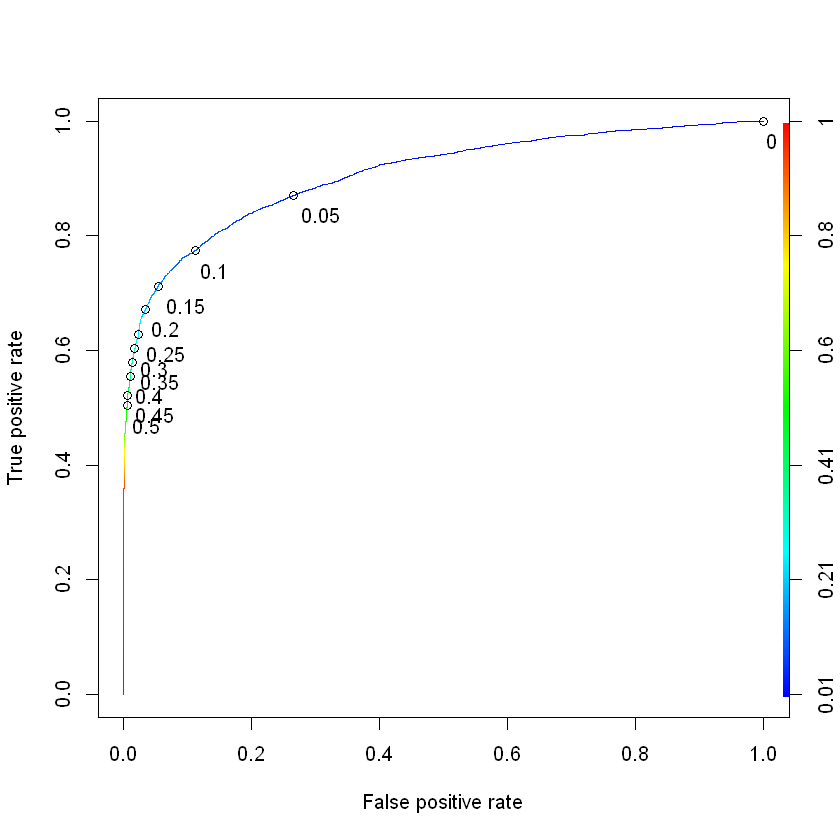

In [52]:
# ROC on train - to finc best cut-off
ROCRpred = prediction(train_pred,train$CASE_STATUS)
ROCRperf  = performance(ROCRpred, "tpr", "fpr")

plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,0.5,by=0.05), 
     text.adj=c(-0.2,1.7))

In [53]:
# performance metrics
confusionMatrix(ifelse(train_pred>0.046,1,0),train$CASE_STATUS,positive = "1")
confusionMatrix(ifelse(test_pred>0.046,1,0),test$CASE_STATUS,positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 50733   937
         1 21155  7009
                                             
               Accuracy : 0.7233             
                 95% CI : (0.7202, 0.7264)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2758             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.88208            
            Specificity : 0.70572            
         Pos Pred Value : 0.24886            
         Neg Pred Value : 0.98187            
             Prevalence : 0.09953            
         Detection Rate : 0.08779            
   Detection Prevalence : 0.35278            
      Balanced Accuracy : 0.79390            
                                             
       'Positive' Class : 1                  
    

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12623   225
         1  5349  1761
                                             
               Accuracy : 0.7207             
                 95% CI : (0.7144, 0.7269)   
    No Information Rate : 0.9005             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2743             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.88671            
            Specificity : 0.70237            
         Pos Pred Value : 0.24768            
         Neg Pred Value : 0.98249            
             Prevalence : 0.09951            
         Detection Rate : 0.08824            
   Detection Prevalence : 0.35625            
      Balanced Accuracy : 0.79454            
                                             
       'Positive' Class : 1                  
    

---
## 3.	Variable Importance (Using RandoForest)
<a id = 'vimp'></a>

In [54]:
# using random-forest built using h2o
h2o.varimp(lca_rf)

variable,relative_importance,scaled_importance,percentage
ABOVE_PW,48085.2109,1.000000000,0.3285364746
AGENT_REPRESENTING_EMPLOYER,29654.6875,0.616711187,0.2026121191
PW_WAGE_LEVEL,14184.1406,0.294979274,0.0969114509
BUFFER_DAYS,13458.8877,0.279896613,0.0919562466
PW_SOURCE,7116.4785,0.147997240,0.0486224916
WAGE_RATE_OF_PAY_FROM,5465.2100,0.113656774,0.0373403959
NEW_EMPLOYMENT,4974.3882,0.103449441,0.0339869146
LABOR_CON_AGREE,4600.6260,0.095676527,0.0314332288
TOTAL_WORKERS,2612.1819,0.054324018,0.0178474215
SUPPORT_H1B,2203.4871,0.045824631,0.0150550628


In [55]:
# building model in R
model_rf = randomForest(y=train$CASE_STATUS, x = train[setdiff(names(train),"CASE_STATUS")],
                  ytest = test$CASE_STATUS, xtest = test[setdiff(names(train),"CASE_STATUS")],
                  ntree = 50,  mtry = 3, keep.forest = TRUE, classwt = c(0.8,0.2))

In [56]:
model_rf


Call:
 randomForest(x = train[setdiff(names(train), "CASE_STATUS")],      y = train$CASE_STATUS, xtest = test[setdiff(names(train),          "CASE_STATUS")], ytest = test$CASE_STATUS, ntree = 50,      mtry = 3, classwt = c(0.8, 0.2), keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 3

        OOB estimate of  error rate: 5.26%
Confusion matrix:
      0    1 class.error
0 70706 1182  0.01644224
1  3021 4925  0.38019129
                Test set error rate: 5.19%
Confusion matrix:
      0    1 class.error
0 17657  315  0.01752726
1   720 1266  0.36253776

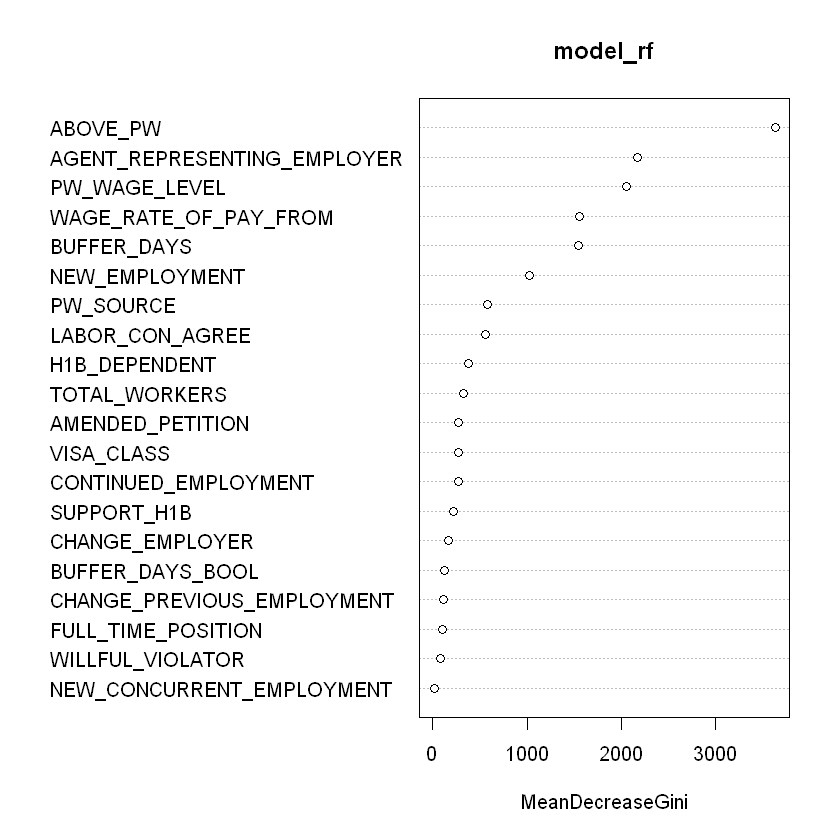

In [57]:
varImpPlot(model_rf,type=2)

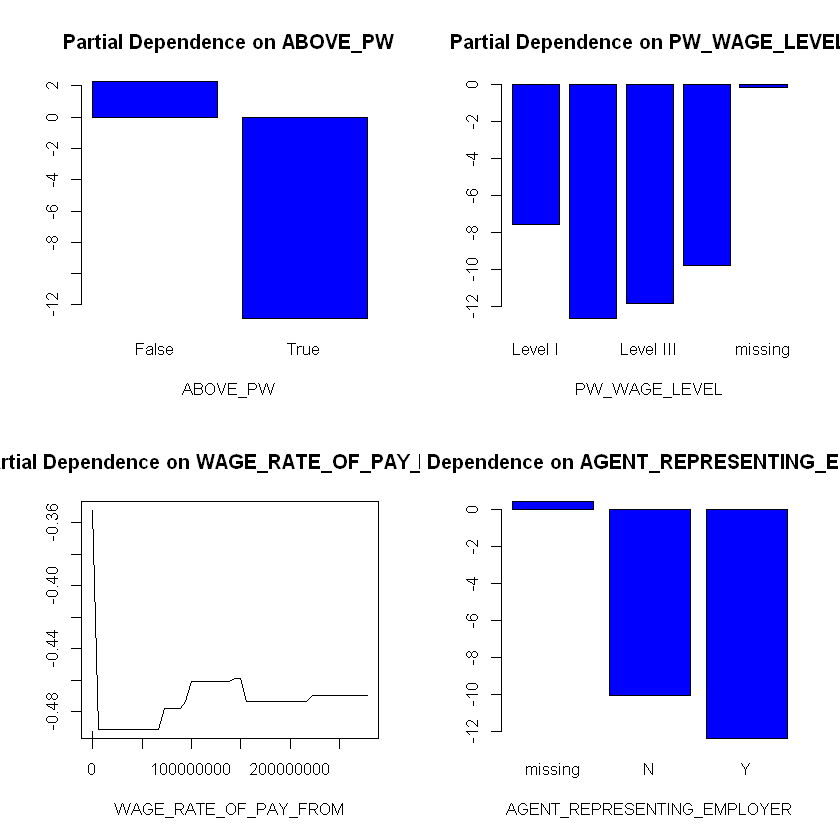

In [58]:
# Partial Dependence - plots
op <- par(mfrow=c(2, 2))
partialPlot(model_rf, train, ABOVE_PW, 1)
partialPlot(model_rf, train, PW_WAGE_LEVEL, 1)
partialPlot(model_rf, train, WAGE_RATE_OF_PAY_FROM, 1)
partialPlot(model_rf, train, AGENT_REPRESENTING_EMPLOYER, 1)

In [59]:
#install.packages("rpart.plot",repos = 'http://cran.us.r-project.org')